In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from PIL import Image
import os
import glob

In [2]:
def load_image(image_path):
    pil_image = Image.open(image_path)

    # convert image to array
    image = np.array(pil_image.convert('RGB'))
    print(f"Image loaded: {image.shape}")
    return image

def display_image(image, title="Image", figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def rgb_to_grayscale(image):
    # RGB to grayscal with intensity
    return np.dot(image[...,:3], [0.299, 0.587, 0.114])

def rgb_to_hsv(rgb):
    # normalize rgb
    rgb = rgb.astype(np.float32) / 255.0
    
    max_val = np.max(rgb, axis=-1)
    min_val = np.min(rgb, axis=-1)
    diff = max_val - min_val

    # hsv model use Hue, Saturation, and Value(Brightness)
    v = max_val
    s = np.where(max_val != 0, diff / max_val, 0)
    h = np.zeros_like(max_val)

    # this section use ai help
    idx = (max_val == rgb[..., 0]) & (diff != 0)
    h[idx] = 60 * ((rgb[..., 1][idx] - rgb[..., 2][idx]) / diff[idx]) % 360
    
    idx = (max_val == rgb[..., 1]) & (diff != 0)
    h[idx] = 60 * ((rgb[..., 2][idx] - rgb[..., 0][idx]) / diff[idx]) + 120
    
    idx = (max_val == rgb[..., 2]) & (diff != 0)
    h[idx] = 60 * ((rgb[..., 0][idx] - rgb[..., 1][idx]) / diff[idx]) + 240
    
    return np.stack([h, s * 255, v * 255], axis=-1)

In [3]:
def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2

    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center # magin from center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2)) #G(x,y) = e^(-(x²+y²)/(2σ²))
    
    return kernel / np.sum(kernel)

# this section use ai help
def convolve2d_single(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    result = np.zeros_like(image)
    
    for i in range(h):
        for j in range(w):
            result[i, j] = np.sum(padded[i:i+kh, j:j+kw] * kernel)
    
    return result

# this section use ai help
def convolve2d(image, kernel):
    if len(image.shape) == 3:
        result = np.zeros_like(image)
        for channel in range(image.shape[2]):
            result[:, :, channel] = convolve2d_single(image[:, :, channel], kernel)
        return result
    else:
        return convolve2d_single(image, kernel)

def gaussian_blur(image, kernel_size=5, sigma=1.0):
    kernel = gaussian_kernel(kernel_size, sigma)
    return convolve2d(image, kernel)

In [4]:
def sobel_edge_detection(image):
    if len(image.shape) == 3:
        gray = rgb_to_grayscale(image)
    else:
        gray = image
    
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) # vertical
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) # horizontal
    
    gx = convolve2d_single(gray, sobel_x)
    gy = convolve2d_single(gray, sobel_y)

    # this section use ai help
    magnitude = np.sqrt(gx**2 + gy**2)
    direction = np.arctan2(gy, gx)
    
    return magnitude, direction, gx, gy

def non_maximum_suppression(magnitude, direction):
    h, w = magnitude.shape
    suppressed = np.zeros_like(magnitude)
    angle = direction * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, h-1):
        for j in range(1, w-1):
            q = 255
            r = 255
            
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            elif (22.5 <= angle[i,j] < 67.5):
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            elif (67.5 <= angle[i,j] < 112.5):
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]
            
            if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                suppressed[i,j] = magnitude[i,j]
            else:
                suppressed[i,j] = 0
    
    return suppressed

def hysteresis_tracking(strong, weak):
    final = strong.copy()
    h, w = strong.shape
    
    for i in range(1, h-1):
        for j in range(1, w-1):
            if weak[i,j]:
                if np.any(strong[i-1:i+2, j-1:j+2]):
                    final[i,j] = True
    
    return final

def canny_edge_detection(image, low_threshold=50, high_threshold=150):
    blurred = gaussian_blur(image, kernel_size=5, sigma=1.4)
    magnitude, direction, gx, gy = sobel_edge_detection(blurred)
    edges = non_maximum_suppression(magnitude, direction)
    
    strong_edges = edges > high_threshold
    weak_edges = (edges > low_threshold) & (edges <= high_threshold)
    
    final_edges = hysteresis_tracking(strong_edges, weak_edges)
    
    return final_edges.astype(np.uint8) * 255

In [5]:
def preprocess_image(image):
    smoothed = gaussian_blur(image, kernel_size=5, sigma=1.0)
    enhanced = np.clip(smoothed * 1.2 + 10, 0, 255).astype(np.uint8)
    return enhanced

def detect_orientation(image):
    edges = canny_edge_detection(image)
    h, w = edges.shape
    
    column_votes = np.sum(edges, axis=0)
    
    row_votes = np.sum(edges, axis=1)
    
    max_col_vote = np.max(column_votes) if len(column_votes) > 0 else 0
    max_row_vote = np.max(row_votes) if len(row_votes) > 0 else 0
    
    if max_col_vote > max_row_vote:
        return "vertical"
    else:
        return "horizontal"

def find_vertical_lines(edges):
    h, w = edges.shape
    column_votes = np.sum(edges, axis=0)
    center_region = slice(w//4, 3*w//4)
    center_votes = column_votes[center_region]
    
    if np.max(center_votes) > h * 0.1:
        best_col = np.argmax(center_votes) + w//4
        return best_col
    
    return w // 2

def find_horizontal_lines(edges):
    h, w = edges.shape
    row_votes = np.sum(edges, axis=1)
    center_region = slice(h//4, 3*h//4)
    center_votes = row_votes[center_region]
    
    if np.max(center_votes) > w * 0.1:
        best_row = np.argmax(center_votes) + h//4
        return best_row
    
    return h // 2

def segment_regions(image):
    height, width = image.shape[:2]
    orientation = detect_orientation(image)
    edges = canny_edge_detection(image)
    
    print(f"Detected orientation: {orientation}")
    
    if orientation == "vertical":
        split_x = find_vertical_lines(edges)
        color_bar = image[:, :split_x]
        object_region = image[:, split_x:]
    else:  
        split_y = find_horizontal_lines(edges)
        color_bar = image[:split_y, :]
        object_region = image[split_y:, :]
    
    return color_bar, object_region, edges, orientation

In [6]:
def remove_background_colors(pixels, white_threshold=240, min_saturation=30):
    hsv_pixels = rgb_to_hsv(pixels.reshape(-1, 1, 3)).reshape(-1, 3)
    
    white_mask = np.all(pixels >= white_threshold, axis=1)
    saturation_mask = hsv_pixels[:, 1] >= min_saturation
    
    valid_mask = ~white_mask & saturation_mask
    
    if np.sum(valid_mask) == 0:
        print("Warning: No valid colors found, using relaxed filtering")
        white_mask = np.all(pixels >= 250, axis=1)
        valid_mask = ~white_mask
    
    return pixels[valid_mask], valid_mask

def extract_dominant_colors_from_colorbar(image, n_colors=7, remove_background=True):
    pixels = image.reshape(-1, 3)
    
    if remove_background:
        filtered_pixels, valid_mask = remove_background_colors(pixels)
        
        if len(filtered_pixels) < n_colors:
            print(f"Warning: Found only {len(filtered_pixels)} valid pixels")
            filtered_pixels = pixels
            valid_mask = np.ones(len(pixels), dtype=bool)
    else:
        filtered_pixels = pixels
        valid_mask = np.ones(len(pixels), dtype=bool)
    
    actual_n_colors = min(n_colors, len(filtered_pixels))
    
    if actual_n_colors < 2:
        print("Warning: Insufficient data for clustering")
        return np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], 
                        [255, 0, 255], [0, 255, 255], [255, 128, 0]]), np.ones(7) / 7
    
    kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
    kmeans.fit(filtered_pixels)
    
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_
    percentages = np.bincount(labels) / len(labels)
    
    sorted_indices = np.argsort(percentages)[::-1]
    colors = colors[sorted_indices]
    percentages = percentages[sorted_indices]
    
    return colors.astype(int), percentages

def extract_dominant_colors_from_object(image, n_colors=3, remove_background=True):
    pixels = image.reshape(-1, 3)
    
    if remove_background:
        filtered_pixels, valid_mask = remove_background_colors(pixels)
        
        if len(filtered_pixels) < n_colors:
            print(f"Warning: Found only {len(filtered_pixels)} valid pixels")
            filtered_pixels = pixels
            valid_mask = np.ones(len(pixels), dtype=bool)
    else:
        filtered_pixels = pixels
        valid_mask = np.ones(len(pixels), dtype=bool)
    
    actual_n_colors = min(n_colors, len(filtered_pixels))
    
    if actual_n_colors < 2:
        print("Warning: Insufficient data for clustering")
        return np.array([[139, 69, 19]]), np.array([1.0])
    
    kmeans = KMeans(n_clusters=actual_n_colors, random_state=42, n_init=10)
    kmeans.fit(filtered_pixels)
    
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_
    percentages = np.bincount(labels) / len(labels)
    
    sorted_indices = np.argsort(percentages)[::-1]
    colors = colors[sorted_indices]
    percentages = percentages[sorted_indices]
    
    return colors.astype(int), percentages

def calculate_color_moments(image):
    moments = {}
    
    for i, channel in enumerate(['R', 'G', 'B']):
        channel_data = image[:, :, i].flatten()
        
        mean = np.mean(channel_data)
        variance = np.var(channel_data)
        
        if variance > 0:
            skewness = np.mean(((channel_data - mean) / np.sqrt(variance)) ** 3)
        else:
            skewness = 0
        
        moments[channel] = {
            'mean': mean,
            'variance': variance,
            'skewness': skewness
        }
    
    return moments

In [7]:
def calculate_color_distance(color1, color2, method='euclidean'):
    if method == 'euclidean':
        return euclidean(color1, color2)
    elif method == 'manhattan':
        return np.sum(np.abs(color1 - color2))
    elif method == 'cosine':
        dot_product = np.dot(color1, color2)
        norms = np.linalg.norm(color1) * np.linalg.norm(color2)
        if norms == 0:
            return 0
        return 1 - (dot_product / norms)

def find_closest_color_match(color_bar_colors, object_colors):
    min_distance = float('inf')
    best_match = None
    distances = []
    
    for i, bar_color in enumerate(color_bar_colors):
        for j, obj_color in enumerate(object_colors):
            distance = calculate_color_distance(bar_color, obj_color)
            distances.append({
                'bar_color_idx': i,
                'object_color_idx': j,
                'bar_color': bar_color,
                'object_color': obj_color,
                'distance': distance
            })
            
            if distance < min_distance:
                min_distance = distance
                best_match = {
                    'bar_color_idx': i,
                    'object_color_idx': j,
                    'bar_color': bar_color,
                    'object_color': obj_color,
                    'distance': distance
                }
    
    return best_match, distances

In [8]:
def display_color_palette(colors, percentages, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for i, (color, percentage) in enumerate(zip(colors, percentages)):
        ax1.add_patch(plt.Rectangle((i, 0), 1, 1, color=color/255))
        ax1.text(i+0.5, 0.5, f'{percentage:.1%}', ha='center', va='center', 
                fontweight='bold', fontsize=10)
    
    ax1.set_xlim(0, len(colors))
    ax1.set_ylim(0, 1)
    ax1.set_title(f"{title} - Colors & Percentages")
    ax1.set_xticks(range(len(colors)))
    ax1.set_xticklabels([f'Color {i+1}' for i in range(len(colors))])
    ax1.set_yticks([])
    
    color_data = []
    for i, color in enumerate(colors):
        color_data.append([f'Color {i+1}', color[0], color[1], color[2]])
    
    table = ax2.table(cellText=color_data,
                     colLabels=['Color', 'R', 'G', 'B'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    ax2.axis('off')
    ax2.set_title("RGB Values")
    
    plt.tight_layout()
    plt.show()

def display_segmentation_results(original, color_bar, object_region, edges, orientation):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0,0].imshow(original)
    axes[0,0].set_title("Original Image")
    axes[0,0].axis('off')
    
    axes[0,1].imshow(color_bar)
    axes[0,1].set_title(f"Color Bar ({orientation})")
    axes[0,1].axis('off')
    
    axes[1,0].imshow(object_region)
    axes[1,0].set_title("Object Region")
    axes[1,0].axis('off')
    
    axes[1,1].imshow(edges, cmap='gray')
    axes[1,1].set_title("Edge Detection")
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()

def bitslicing_analysis(image, bit_plane=7):
    gray = rgb_to_grayscale(image)
    bit_image = (gray.astype(np.uint8) >> bit_plane) & 1
    bit_image = bit_image * 255
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(image)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    ax2.imshow(bit_image, cmap='gray')
    ax2.set_title(f"Bit Slice {bit_plane} (MSB)")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return bit_image

In [9]:
def process_image_batch(image_folder_path):
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    image_files = []
    
    for extension in image_extensions:
        image_files.extend(glob.glob(os.path.join(image_folder_path, extension)))
    
    print(f"Found {len(image_files)} images to process")
    
    all_results = []
    
    for i, image_path in enumerate(image_files):
        print(f"\n{'='*50}")
        print(f"Processing image {i+1}/{len(image_files)}: {os.path.basename(image_path)}")
        print(f"{'='*50}")
        
        try:
            result = analyze_single_image(image_path, show_plots=False)
            result['filename'] = os.path.basename(image_path)
            all_results.append(result)
            print(f"Successfully processed {os.path.basename(image_path)}")
            
        except Exception as e:
            print(f"Error processing {os.path.basename(image_path)}: {str(e)}")
            continue
    
    return all_results

def analyze_single_image(image_path, show_plots=True):
    # Load image
    original_image = load_image(image_path)
    
    # Preprocess
    processed_image = preprocess_image(original_image)
    
    # Segment
    color_bar_region, object_region, edges, orientation = segment_regions(processed_image)
    
    # Extract colors
    bar_colors, bar_percentages = extract_dominant_colors_from_colorbar(
        color_bar_region, n_colors=7, remove_background=True
    )
    
    obj_colors, obj_percentages = extract_dominant_colors_from_object(
        object_region, n_colors=3, remove_background=True
    )
    
    # Find best match
    best_match, all_distances = find_closest_color_match(bar_colors, obj_colors)
    
    # Calculate moments
    bar_moments = calculate_color_moments(color_bar_region)
    obj_moments = calculate_color_moments(object_region)
    
    if show_plots:
        display_segmentation_results(original_image, color_bar_region, 
                                   object_region, edges, orientation)
        display_color_palette(bar_colors, bar_percentages, "Color Bar Palette")
        display_color_palette(obj_colors, obj_percentages, "Object Palette")
    
    return {
        'original_shape': original_image.shape,
        'orientation': orientation,
        'bar_colors': bar_colors,
        'bar_percentages': bar_percentages,
        'obj_colors': obj_colors,
        'obj_percentages': obj_percentages,
        'best_match': best_match,
        'bar_moments': bar_moments,
        'obj_moments': obj_moments
    }

Image loaded: (1350, 1250, 3)
Detected orientation: vertical


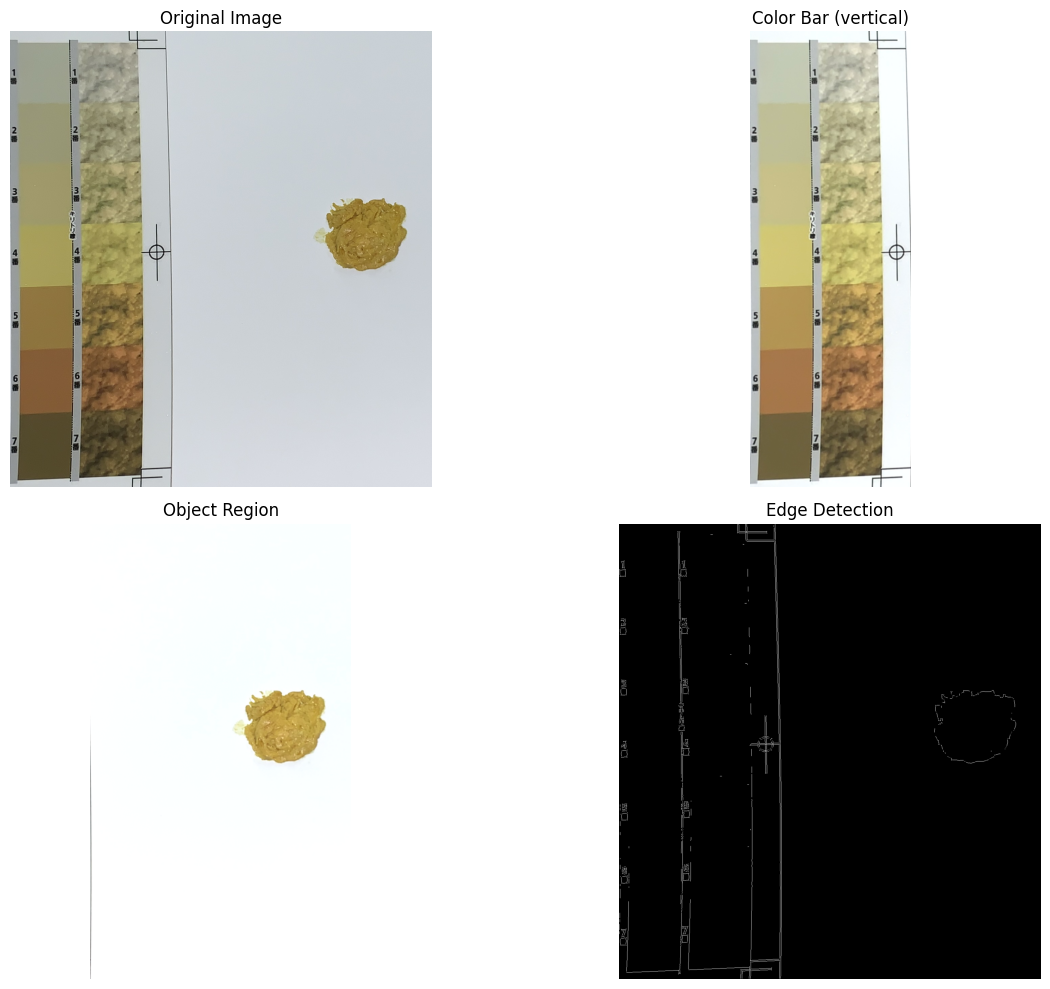

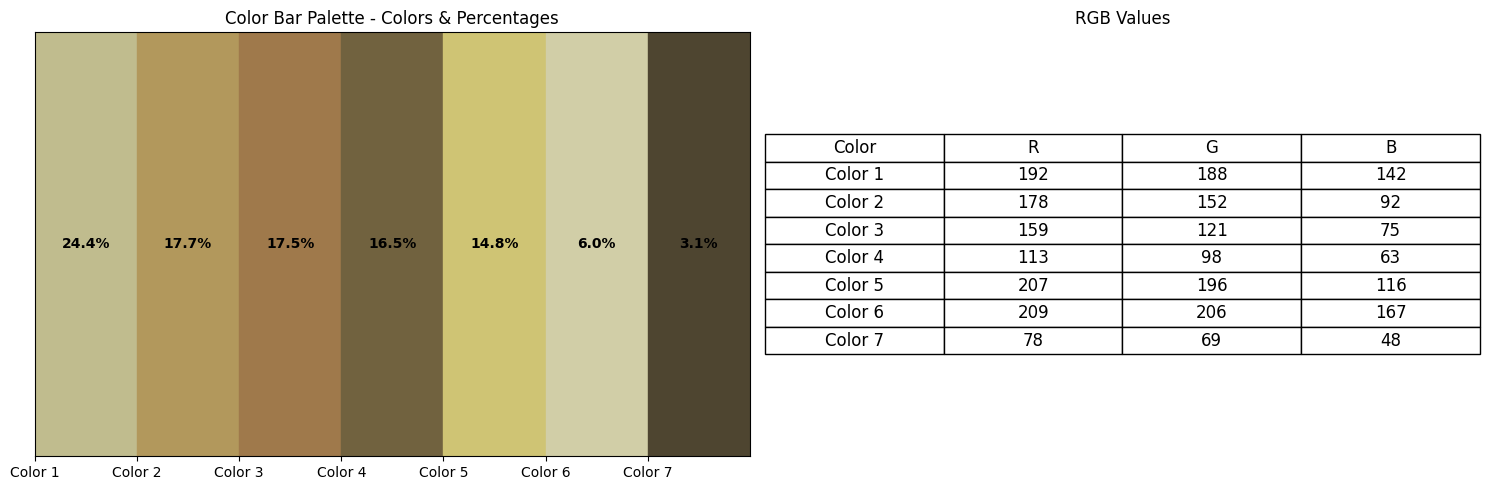

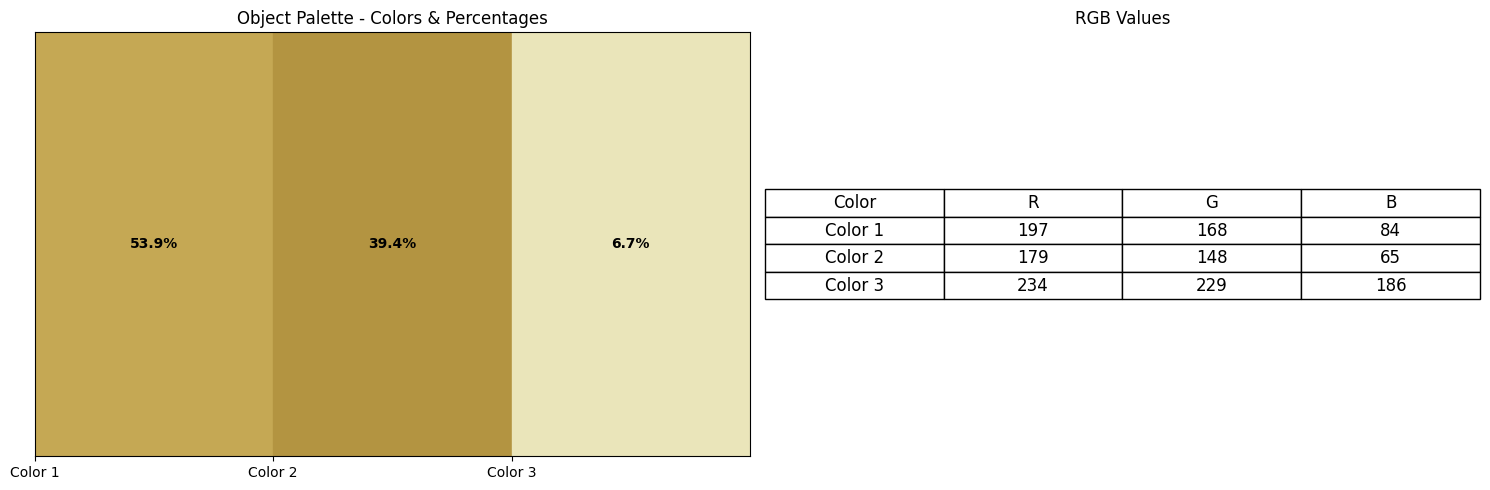

In [10]:
result = analyze_single_image('image_crop/106100864.png')

Image loaded: (700, 700, 3)
Detected orientation: horizontal


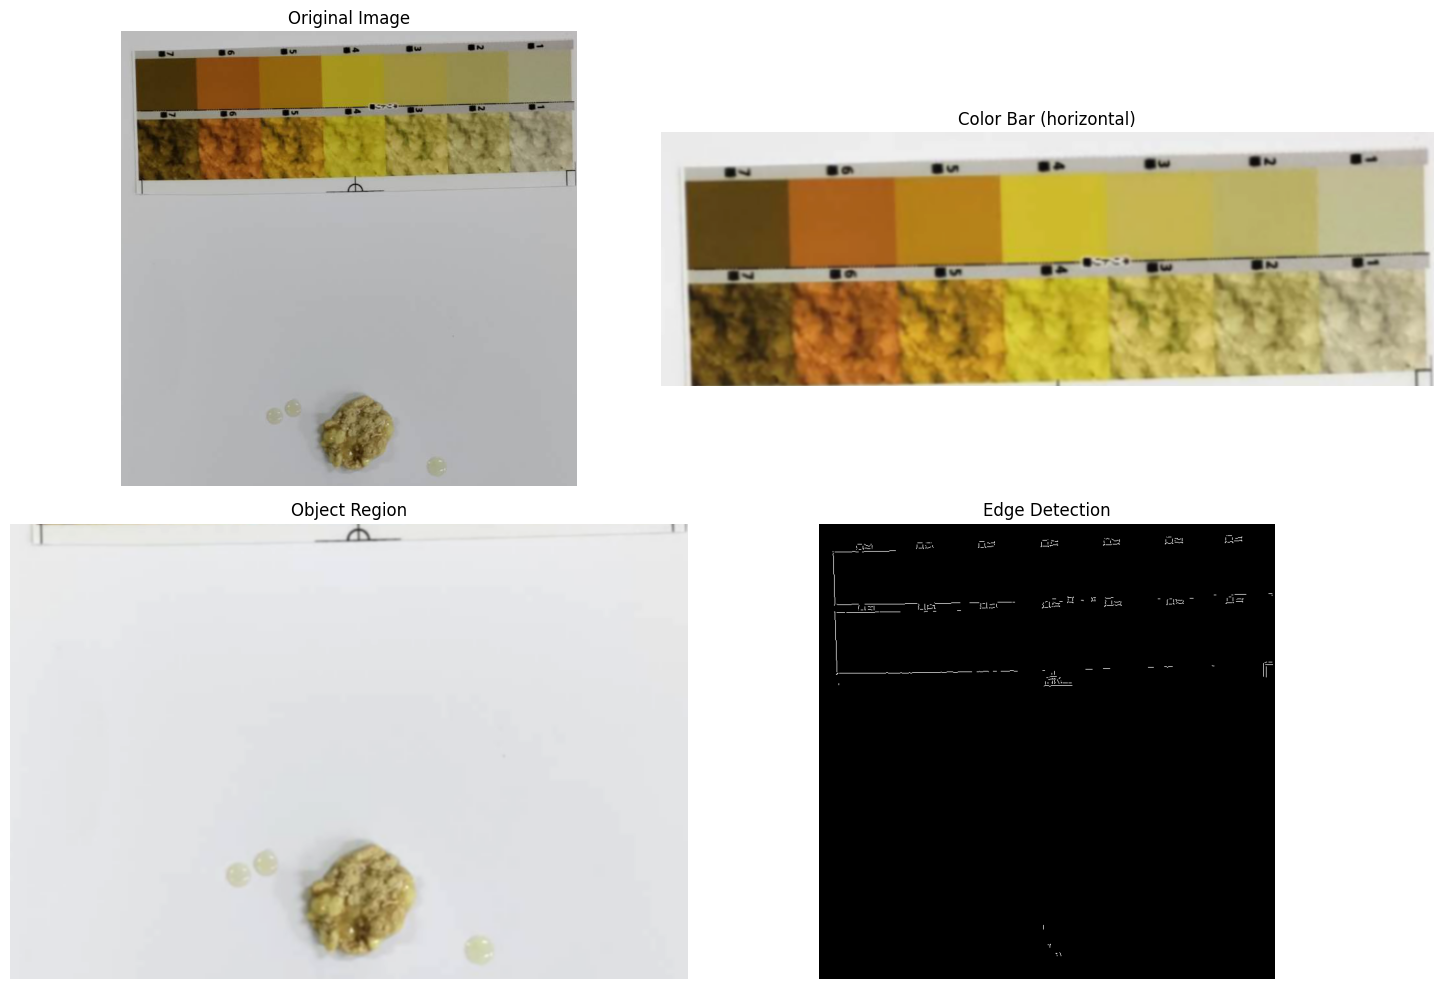

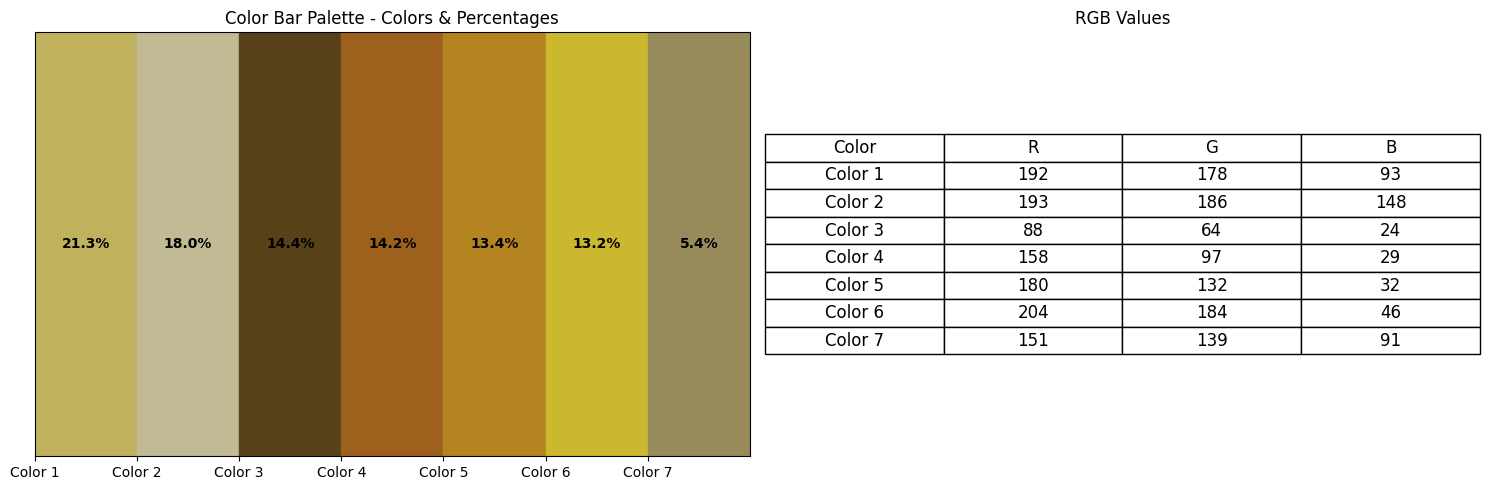

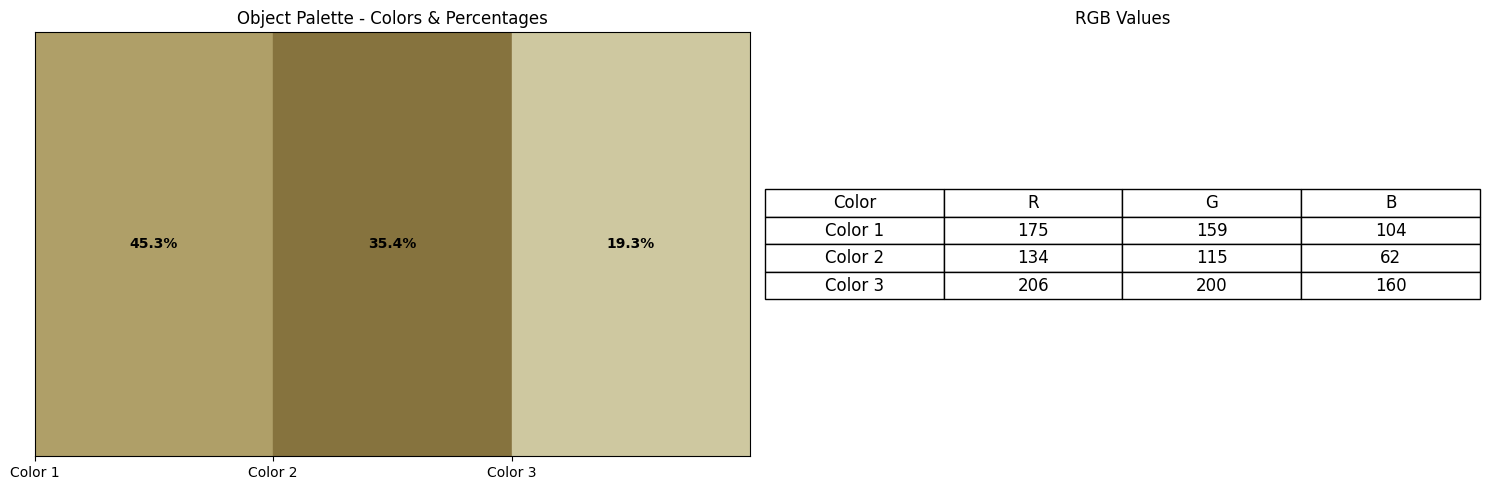

In [11]:
result_hori = analyze_single_image('image_crop/405241263.png')

In [12]:
# batch_results = process_image_batch('image_crop')